### Machine Learning Project - Killian Pluzanski et Romain Michaud - ENSAE ParisTech

## Predicting the Leverage Effect in Financial Markets with a Feed-Forward Neural Network for Optimal Asset Allocation in a Risk-Parity Framework


**Executive Summary**:

- Introduction
- Part I - The Leverage Effect in Financial Markets - NoteBook I
- Part II - Measuring the Reactive Covariance Matrix using our Leverage Effect Prediction - NoteBook II
- Part III - Optimal Asset Allocation based on this prediction in a Risk-Parity Framework - NoteBook III
- Bibliography 

## Introduction

The leverage effect is a well-known stylized fact of financial markets and it refers to the negative volatility-return correlation of stock prices: volatility of stocks tends to increase when prices drop. **This first section empirically investigate this so-called leverage effect. Using a sample of index returns spanning 30 years, we propose an estimation of the the leverage effect using a simple feed-forward neural network.**

In the second section, we **introduce the reactive volatility measure discussed by Valeyre et al. in 2018**. We then extend this reactive volatility measure to the multivariate framework by estimating a reactive variance-covariance matrix.

**The third section will be dedicated to estimating the performance and risk of portfolios investing in risky assets using the reactive variance-covariance matrix built using our initial leverage effect prediction**. We test the portfolio in a risk-parity framework - which exhibits a high sensitivity to the volatility (and covariance) measure. 


## Part I - Leverage Effect in Financial Markets

### 1.1 - What is the leverage effect?

Several stylized facts from financial markets such as "fat tails" in the distribution of asset returns and long ranged volatility correlation have recently become the focus of detailed empirical studies.
In particular, a well-known stylized fact is the so-called "leverage effect" first discussed by Black in 1976. 

**The leverage effect refers to the negative volatility-return correlation of stock prices**: volatility of stocks tends to increase when prices drop. 

Two competing theories have been put forward to explain this leverage effect. The first lies at the individual firm’s level and postulates that a drop in the value of a stock increases the financial leverage of the company: as the share price decreases, the stock becomes riskier which in turn increases its volatility (Christie, 1982). 

The second explanation is derived from the existence of time-varying risk premiums (Pindyck, 1984) and lies at the market’s level: an increase in volatility raises the return on equity, which triggers a stock price decline. As noted by Bekaerst and Wu (2000), “the causality is different: the leverage hypothesis claims that return shocks lead to changes in conditional volatility, whereas the time-varying risk premium theory contends that return shocks are caused by changes in conditional volatility”. 



Let $\mathcal{L}_{i}(\tau)$ be the correlation function between $(\delta x_{i}(t+\tau))^{2}$, the daily volatility proxy at time $t+\tau$ avec $\tau > 0$, and the return $\delta x_{i}(t)$. The leverage effect is given by:
    \begin{equation}
		\mathcal{L}_{i}(\tau) = \dfrac{1}{Z}\langle (\delta x_{i}(t+\tau))^{2}, \delta x_{i}(t) \rangle
	\end{equation}
	with $Z = \langle \delta x_{i}(t)^{2} \rangle ^{2}$.
	\\
	\An empirical estimator of this quantity is given by:
	\begin{equation}\label{eq: fonction de levier}
		\hat{\mathcal{L}}_{i}(\tau) = \dfrac{1}{\hat{Z}}\dfrac{1}{T-(\tau+1)}\sum\limits_{t=0}^{T-(\tau+1)} \left((\delta x_{i}(t+\tau))^{2}*\delta x_{i}(t) \right)
	\end{equation}
	with $\hat{Z} = \dfrac{1}{T-1}\left(\sum\limits_{t=0}^{T-1} \delta x_{i}(t)^{2}\right)^{2}$
	\\

### 1.2 - Practical Implementation: Computing the Leverage Effect on a Series of Indices

In [1]:
# Import relevant libraries

import matplotlib.pyplot as plt
import pandas as pd
import os
import fnmatch
import random
import scipy as sp
from scipy.optimize import curve_fit
import numpy as np

In [16]:
## This creates a dictionnary with the data

index_df = pd.read_excel('Data\indices.xls') # importer l'Excel de prix 
index_df = index_df[0:len(index_df) -250]

index_dictionnary = {0 : "STOXX 600", 1:"STOXX 50",2 : "S&P 500", 3 : "TOPIX", 4: "FTSE", 5:"DAX", 6:"NIKKEI",7:"NASDAQ"}
index_df.tail()

,Date,STOXX 600,STOXX 50,S&P 500,TOPIX,FTSE,DAX,NIKKEI,NASDAQ
7219,2017-09-01,376.136,3443.882,2476.55,1619.59,7438.50,12142.63965,19691.47070,6435.33
7220,2017-09-04,374.183,3430.418,2476.55,1603.55,7411.47,12102.20996,19508.25000,6435.33
7221,2017-09-05,373.713,3420.860,2457.85,1590.71,7372.92,12123.70996,19385.81055,6375.57
7222,2017-09-06,373.949,3433.805,2465.54,1592.00,7354.13,12214.54004,19357.97070,6393.31
7223,2017-09-07,374.947,3447.656,2465.10,1598.24,7396.98,12296.62988,19396.51953,6397.87


In [3]:
## Le but de cette classe est de regrouper les méthodes permettant le calcul du leverage
## L'idée est ensuite de pouvoir calculer rapidement le leverage en loopant sur des centaines de stocks et indices 

class ComputeLeverage: 
    
    def __init__(self): ## Méthode du constructeur
        self.ticker = Ticker ## on construit l'objet prenant comme parametre le ticker du stock
        self.df = pd.read_excel('Data\indices.xls')
        self.tau = Tau
        # On importe les données dans la construction de l'objet. La dataframe "df" sera utilisee par les autres méthodes de la classe
    
    def deltaTau(self,tau): # Cette fonction calcule la variation du prix entre t et t + tau (delta x(t+tau)) 
        return ((self.df[Ticker].shift(-tau) - self.df[Ticker].shift(-tau+1))/self.df[Ticker].shift(-tau+1))
    
    def zHat(self,tau,T): # Cette fonction calcule Z chapeau
        self.df["Interm_Z"] = (self.deltaTau(0)**2)  # Calcule l'intérieur de la somme 
        return ((1/(T-1))*(self.df["Interm_Z"].sum()))**2 # Retourne la somme des carrés normalisé par T
        
    def lHat(self,tau,T): 
        self.df["Interm_Prod_Delta"]  = ((self.deltaTau(tau))**2)*self.deltaTau(0)  # Check if 0 or 1 
        return (1/self.zHat(tau,T))*(self.df["Interm_Prod_Delta"].sum())/((T-tau)) # Divisé par T ou T - Tau ?
    
    def PlotLeverage(self):
        T = self.df.shape[0] # size of our sample
        result_df = pd.DataFrame([])
        for tau in range(0,200): ## specify the max range for the time horizon 
             result_df = result_df.append(pd.DataFrame({"Tau":tau,'L_Hat': self.lHat(tau,T)}, index=[0]), ignore_index=True)
                
        return result_df.plot.scatter(x = "Tau", y = "L_Hat" )
    
    ## C'est exactement la même méthode qu'au dessus. La seule différence est qu'elle retourne le résultat sous forme de tableau et non de graph
    def ReturnLeverage(self):
        T = self.df.shape[0] # size of our sample
        result_df = pd.DataFrame([])
        for tau in range(1,self.tau): ## specify the max range for the time horizon 
            result_df = result_df.append(pd.DataFrame({"Tau":tau,self.ticker: self.lHat(tau,T)}, index=[0]), ignore_index=True)
        return result_df

In [4]:
Tau = 200  ## On spécifie ici l'horizon de temps qui sera calculé au sein de la classe 

leverage_df = pd.DataFrame({"Tau":range(1,Tau)}) # Création de la première colonne comportant les valeurs de Tau

for key in index_dictionnary:
    Ticker = index_dictionnary.get(key) ## définition du ticker pour la création de l'objet
    myStock = ComputeLeverage() ## Creation de l'objet 
    leverage_df = pd.concat([leverage_df,myStock.ReturnLeverage()[Ticker]], axis=1) # Concaténation du leverage pour chaque stock dans la dataframe Leverage_df

print(leverage_df)

     Tau  STOXX 600   STOXX 50    S&P 500      TOPIX       FTSE        DAX  \
0      1 -28.370510 -22.344797 -31.776935 -18.106882 -21.152076 -17.675235   
1      2 -19.976781 -13.404320 -28.513623 -23.078525 -18.475387 -12.494372   
2      3 -29.818443 -20.229991 -17.285914 -15.960970 -28.158242 -17.495733   
3      4 -18.789958 -13.793239 -25.554852 -22.212422 -14.347965 -15.495401   
4      5 -21.746604 -15.566872 -21.235866  -9.930559 -19.640948  -9.862291   
5      6  -7.242282  -3.767413  -5.004332 -13.146847 -10.131586  -3.747626   
6      7 -12.113918  -7.684583  -9.208798 -13.626596 -14.143810  -5.597536   
7      8 -16.373165 -11.740627 -20.887378 -13.749472 -10.824842  -9.798451   
8      9 -18.553294 -14.623981 -13.515712  -3.040433 -20.104154 -15.300214   
9     10 -20.379428  -9.992938 -22.801192 -18.085851 -19.737801  -8.185892   
10    11  -5.542992  -4.264689  -0.941269  -4.734748   0.900852  -1.094884   
11    12 -15.735704 -13.356544  -7.807460  -3.067428 -14.491680 

### 1.3 - Predicting the Leverage Effect using a Feed-Forward Neural Network

In this section, we will use the empirical leverage effect data calculated previously that we will split into a training and test set. We will then use these sets to approximate the Leverage Function with a Feed-Forward Neural Network.

In [5]:
from sklearn.neural_network import MLPRegressor  # import the NN library

{0: 'NASDAQ', 1: 'NASDAQ', 2: 'NIKKEI', 3: 'S&P 500'}
{0: 'S&P 500', 1: 'NIKKEI', 2: 'NASDAQ', 3: 'NIKKEI', 4: 'STOXX 600'}


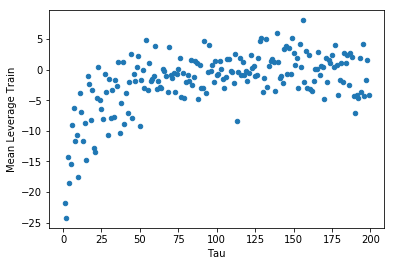

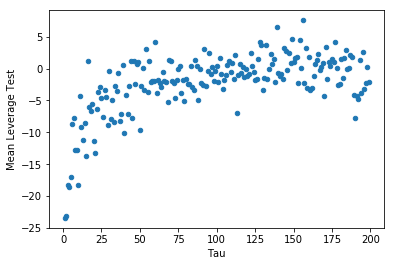

In [6]:
#Let's define our training and test sets 

# The training set will consist of 40% of the data 

n = len(index_dictionnary)

train_dictionnary = {}

for j in range(0,round((n+1)*0.4)):
    train_dictionnary[j] = index_dictionnary[random.choice(list(index_dictionnary.keys()))]

print(train_dictionnary)

# The test set will consist of 60% of the data

test_dictionnary = {}

for j in range(0,round((n+1)*0.6)):
    test_dictionnary[j] = index_dictionnary[random.choice(list(index_dictionnary.keys()))]

print(test_dictionnary)

# Let's create a dataframe with the leverage values of the training set 
mean_leverage_train_df= pd.DataFrame({"Tau":range(1,Tau)})

for key in train_dictionnary:
    mean_leverage_train_df[train_dictionnary.get(key)]  = leverage_df[train_dictionnary.get(key)]

# Let's average the values across the training set
mean_leverage_train_df["Mean Leverage Train"] = mean_leverage_train_df.drop(["Tau"],axis=1).mean(axis=1)

# Let's create a dataframe with the leverage values of the test set 

mean_leverage_test_df= pd.DataFrame({"Tau":range(1,Tau)})

for key in test_dictionnary:
    mean_leverage_test_df[test_dictionnary.get(key)]  = leverage_df[test_dictionnary.get(key)]

# Let's average the values across the test set
mean_leverage_test_df["Mean Leverage Test"] = mean_leverage_test_df.drop(["Tau"],axis=1).mean(axis=1)

# Let's plot the data 
mean_leverage_train_df.plot.scatter(x = "Tau", y = "Mean Leverage Train" ) 
mean_leverage_test_df.plot.scatter(x = "Tau", y = "Mean Leverage Test" ) 


In [7]:
# Training the Neural Network on the train set 

n = Tau-1

x =  mean_leverage_train_df["Tau"]
x = x.values

y = mean_leverage_train_df["Mean Leverage Train"]  
X = np.reshape(x,[n,1])  
y = np.reshape(y ,[n ,])

clf = MLPRegressor(alpha=0.001, hidden_layer_sizes = (15,), max_iter = 10000, 
                 activation = 'logistic', verbose = 'True', learning_rate = 'adaptive')

## Alpha pénalize les poids elevés sur le réseau
# 15 couches cachées 
# Activation avec fonction logistique. Essayer avec tanh et relu 
# learning rate = adaptive : gradually decreases the learning rate

a = clf.fit(X, y)

Iteration 1, loss = 14.27486718
Iteration 2, loss = 14.24974381
Iteration 3, loss = 14.22472959
Iteration 4, loss = 14.19982080
Iteration 5, loss = 14.17501359
Iteration 6, loss = 14.15030404
Iteration 7, loss = 14.12568827
Iteration 8, loss = 14.10116243
Iteration 9, loss = 14.07672272
Iteration 10, loss = 14.05236539
Iteration 11, loss = 14.02808668
Iteration 12, loss = 14.00388284
Iteration 13, loss = 13.97975011
Iteration 14, loss = 13.95568465
Iteration 15, loss = 13.93168256
Iteration 16, loss = 13.90773985
Iteration 17, loss = 13.88385241
Iteration 18, loss = 13.86001604
Iteration 19, loss = 13.83622636
Iteration 20, loss = 13.81247890
Iteration 21, loss = 13.78876902
Iteration 22, loss = 13.76509197
Iteration 23, loss = 13.74144286
Iteration 24, loss = 13.71781672
Iteration 25, loss = 13.69420850
Iteration 26, loss = 13.67061307
Iteration 27, loss = 13.64702532
Iteration 28, loss = 13.62344012
Iteration 29, loss = 13.59985237
Iteration 30, loss = 13.57625707
Iteration 31, loss 

Iteration 349, loss = 10.47254840
Iteration 350, loss = 10.46708506
Iteration 351, loss = 10.46202540
Iteration 352, loss = 10.45732470
Iteration 353, loss = 10.45277955
Iteration 354, loss = 10.44808514
Iteration 355, loss = 10.44301980
Iteration 356, loss = 10.43756651
Iteration 357, loss = 10.43186356
Iteration 358, loss = 10.42608865
Iteration 359, loss = 10.42037865
Iteration 360, loss = 10.41480373
Iteration 361, loss = 10.40937620
Iteration 362, loss = 10.40407242
Iteration 363, loss = 10.39885364
Iteration 364, loss = 10.39368010
Iteration 365, loss = 10.38851837
Iteration 366, loss = 10.38334380
Iteration 367, loss = 10.37814051
Iteration 368, loss = 10.37290019
Iteration 369, loss = 10.36762083
Iteration 370, loss = 10.36230540
Iteration 371, loss = 10.35696069
Iteration 372, loss = 10.35159616
Iteration 373, loss = 10.34622272
Iteration 374, loss = 10.34085148
Iteration 375, loss = 10.33549237
Iteration 376, loss = 10.33015282
Iteration 377, loss = 10.32483656
Iteration 378,

Iteration 697, loss = 8.35002833
Iteration 698, loss = 8.34406474
Iteration 699, loss = 8.33811216
Iteration 700, loss = 8.33218170
Iteration 701, loss = 8.32628184
Iteration 702, loss = 8.32041663
Iteration 703, loss = 8.31458536
Iteration 704, loss = 8.30878339
Iteration 705, loss = 8.30300388
Iteration 706, loss = 8.29723935
Iteration 707, loss = 8.29148297
Iteration 708, loss = 8.28572926
Iteration 709, loss = 8.27997459
Iteration 710, loss = 8.27421743
Iteration 711, loss = 8.26845844
Iteration 712, loss = 8.26270028
Iteration 713, loss = 8.25694691
Iteration 714, loss = 8.25120265
Iteration 715, loss = 8.24547114
Iteration 716, loss = 8.23975454
Iteration 717, loss = 8.23405334
Iteration 718, loss = 8.22836658
Iteration 719, loss = 8.22269251
Iteration 720, loss = 8.21702928
Iteration 721, loss = 8.21137531
Iteration 722, loss = 8.20572947
Iteration 723, loss = 8.20009103
Iteration 724, loss = 8.19445950
Iteration 725, loss = 8.18883469
Iteration 726, loss = 8.18321671
Iteration 

Iteration 1059, loss = 6.76051104
Iteration 1060, loss = 6.75745882
Iteration 1061, loss = 6.75441303
Iteration 1062, loss = 6.75137366
Iteration 1063, loss = 6.74834070
Iteration 1064, loss = 6.74531414
Iteration 1065, loss = 6.74229397
Iteration 1066, loss = 6.73928018
Iteration 1067, loss = 6.73627276
Iteration 1068, loss = 6.73327171
Iteration 1069, loss = 6.73027702
Iteration 1070, loss = 6.72728867
Iteration 1071, loss = 6.72430666
Iteration 1072, loss = 6.72133098
Iteration 1073, loss = 6.71836161
Iteration 1074, loss = 6.71539856
Iteration 1075, loss = 6.71244181
Iteration 1076, loss = 6.70949134
Iteration 1077, loss = 6.70654717
Iteration 1078, loss = 6.70360926
Iteration 1079, loss = 6.70067762
Iteration 1080, loss = 6.69775224
Iteration 1081, loss = 6.69483310
Iteration 1082, loss = 6.69192019
Iteration 1083, loss = 6.68901352
Iteration 1084, loss = 6.68611307
Iteration 1085, loss = 6.68321882
Iteration 1086, loss = 6.68033078
Iteration 1087, loss = 6.67744892
Iteration 1088

Iteration 1416, loss = 6.01092951
Iteration 1417, loss = 6.00959768
Iteration 1418, loss = 6.00826905
Iteration 1419, loss = 6.00694361
Iteration 1420, loss = 6.00562135
Iteration 1421, loss = 6.00430226
Iteration 1422, loss = 6.00298633
Iteration 1423, loss = 6.00167353
Iteration 1424, loss = 6.00036388
Iteration 1425, loss = 5.99905734
Iteration 1426, loss = 5.99775391
Iteration 1427, loss = 5.99645358
Iteration 1428, loss = 5.99515634
Iteration 1429, loss = 5.99386217
Iteration 1430, loss = 5.99257106
Iteration 1431, loss = 5.99128299
Iteration 1432, loss = 5.98999797
Iteration 1433, loss = 5.98871596
Iteration 1434, loss = 5.98743697
Iteration 1435, loss = 5.98616098
Iteration 1436, loss = 5.98488797
Iteration 1437, loss = 5.98361793
Iteration 1438, loss = 5.98235084
Iteration 1439, loss = 5.98108671
Iteration 1440, loss = 5.97982551
Iteration 1441, loss = 5.97856722
Iteration 1442, loss = 5.97731184
Iteration 1443, loss = 5.97605935
Iteration 1444, loss = 5.97480973
Iteration 1445

Iteration 1745, loss = 5.67624585
Iteration 1746, loss = 5.67543002
Iteration 1747, loss = 5.67461521
Iteration 1748, loss = 5.67380141
Iteration 1749, loss = 5.67298864
Iteration 1750, loss = 5.67217689
Iteration 1751, loss = 5.67136615
Iteration 1752, loss = 5.67055643
Iteration 1753, loss = 5.66974773
Iteration 1754, loss = 5.66894004
Iteration 1755, loss = 5.66813337
Iteration 1756, loss = 5.66732772
Iteration 1757, loss = 5.66652307
Iteration 1758, loss = 5.66571944
Iteration 1759, loss = 5.66491682
Iteration 1760, loss = 5.66411521
Iteration 1761, loss = 5.66331461
Iteration 1762, loss = 5.66251502
Iteration 1763, loss = 5.66171644
Iteration 1764, loss = 5.66091887
Iteration 1765, loss = 5.66012230
Iteration 1766, loss = 5.65932674
Iteration 1767, loss = 5.65853218
Iteration 1768, loss = 5.65773862
Iteration 1769, loss = 5.65694607
Iteration 1770, loss = 5.65615452
Iteration 1771, loss = 5.65536397
Iteration 1772, loss = 5.65457441
Iteration 1773, loss = 5.65378586
Iteration 1774

Iteration 2120, loss = 5.42867503
Iteration 2121, loss = 5.42813139
Iteration 2122, loss = 5.42758845
Iteration 2123, loss = 5.42704624
Iteration 2124, loss = 5.42650473
Iteration 2125, loss = 5.42596394
Iteration 2126, loss = 5.42542386
Iteration 2127, loss = 5.42488449
Iteration 2128, loss = 5.42434582
Iteration 2129, loss = 5.42380787
Iteration 2130, loss = 5.42327062
Iteration 2131, loss = 5.42273408
Iteration 2132, loss = 5.42219824
Iteration 2133, loss = 5.42166310
Iteration 2134, loss = 5.42112866
Iteration 2135, loss = 5.42059492
Iteration 2136, loss = 5.42006189
Iteration 2137, loss = 5.41952954
Iteration 2138, loss = 5.41899789
Iteration 2139, loss = 5.41846694
Iteration 2140, loss = 5.41793667
Iteration 2141, loss = 5.41740710
Iteration 2142, loss = 5.41687821
Iteration 2143, loss = 5.41635001
Iteration 2144, loss = 5.41582250
Iteration 2145, loss = 5.41529567
Iteration 2146, loss = 5.41476952
Iteration 2147, loss = 5.41424405
Iteration 2148, loss = 5.41371926
Iteration 2149

Iteration 2491, loss = 5.26555436
Iteration 2492, loss = 5.26519954
Iteration 2493, loss = 5.26484509
Iteration 2494, loss = 5.26449101
Iteration 2495, loss = 5.26413729
Iteration 2496, loss = 5.26378394
Iteration 2497, loss = 5.26343095
Iteration 2498, loss = 5.26307833
Iteration 2499, loss = 5.26272607
Iteration 2500, loss = 5.26237417
Iteration 2501, loss = 5.26202263
Iteration 2502, loss = 5.26167145
Iteration 2503, loss = 5.26132063
Iteration 2504, loss = 5.26097017
Iteration 2505, loss = 5.26062007
Iteration 2506, loss = 5.26027033
Iteration 2507, loss = 5.25992094
Iteration 2508, loss = 5.25957191
Iteration 2509, loss = 5.25922323
Iteration 2510, loss = 5.25887491
Iteration 2511, loss = 5.25852693
Iteration 2512, loss = 5.25817932
Iteration 2513, loss = 5.25783205
Iteration 2514, loss = 5.25748513
Iteration 2515, loss = 5.25713856
Iteration 2516, loss = 5.25679234
Iteration 2517, loss = 5.25644647
Iteration 2518, loss = 5.25610095
Iteration 2519, loss = 5.25575577
Iteration 2520

Iteration 2839, loss = 5.15659737
Iteration 2840, loss = 5.15631378
Iteration 2841, loss = 5.15603033
Iteration 2842, loss = 5.15574703
Iteration 2843, loss = 5.15546385
Iteration 2844, loss = 5.15518082
Iteration 2845, loss = 5.15489793
Iteration 2846, loss = 5.15461517
Iteration 2847, loss = 5.15433256
Iteration 2848, loss = 5.15405008
Iteration 2849, loss = 5.15376774
Iteration 2850, loss = 5.15348554
Iteration 2851, loss = 5.15320347
Iteration 2852, loss = 5.15292155
Iteration 2853, loss = 5.15263976
Iteration 2854, loss = 5.15235812
Iteration 2855, loss = 5.15207661
Iteration 2856, loss = 5.15179523
Iteration 2857, loss = 5.15151400
Iteration 2858, loss = 5.15123291
Iteration 2859, loss = 5.15095195
Iteration 2860, loss = 5.15067113
Iteration 2861, loss = 5.15039045
Iteration 2862, loss = 5.15010991
Iteration 2863, loss = 5.14982951
Iteration 2864, loss = 5.14954925
Iteration 2865, loss = 5.14926912
Iteration 2866, loss = 5.14898914
Iteration 2867, loss = 5.14870929
Iteration 2868

Iteration 3220, loss = 5.06146726
Iteration 3221, loss = 5.06126099
Iteration 3222, loss = 5.06105497
Iteration 3223, loss = 5.06084919
Iteration 3224, loss = 5.06064366
Iteration 3225, loss = 5.06043838
Iteration 3226, loss = 5.06023334
Iteration 3227, loss = 5.06002854
Iteration 3228, loss = 5.05982399
Iteration 3229, loss = 5.05961969
Iteration 3230, loss = 5.05941563
Iteration 3231, loss = 5.05921181
Iteration 3232, loss = 5.05900824
Iteration 3233, loss = 5.05880491
Iteration 3234, loss = 5.05860183
Iteration 3235, loss = 5.05839899
Iteration 3236, loss = 5.05819639
Iteration 3237, loss = 5.05799403
Iteration 3238, loss = 5.05779192
Iteration 3239, loss = 5.05759005
Iteration 3240, loss = 5.05738842
Iteration 3241, loss = 5.05718703
Iteration 3242, loss = 5.05698588
Iteration 3243, loss = 5.05678497
Iteration 3244, loss = 5.05658431
Iteration 3245, loss = 5.05638388
Iteration 3246, loss = 5.05618370
Iteration 3247, loss = 5.05598375
Iteration 3248, loss = 5.05578405
Iteration 3249

Iteration 3592, loss = 4.99851592
Iteration 3593, loss = 4.99836854
Iteration 3594, loss = 4.99822112
Iteration 3595, loss = 4.99807367
Iteration 3596, loss = 4.99792617
Iteration 3597, loss = 4.99777864
Iteration 3598, loss = 4.99763106
Iteration 3599, loss = 4.99748343
Iteration 3600, loss = 4.99733576
Iteration 3601, loss = 4.99718804
Iteration 3602, loss = 4.99704027
Iteration 3603, loss = 4.99689245
Iteration 3604, loss = 4.99674457
Iteration 3605, loss = 4.99659665
Iteration 3606, loss = 4.99644867
Iteration 3607, loss = 4.99630063
Iteration 3608, loss = 4.99615253
Iteration 3609, loss = 4.99600437
Iteration 3610, loss = 4.99585616
Iteration 3611, loss = 4.99570788
Iteration 3612, loss = 4.99555954
Iteration 3613, loss = 4.99541114
Iteration 3614, loss = 4.99526267
Iteration 3615, loss = 4.99511414
Iteration 3616, loss = 4.99496553
Iteration 3617, loss = 4.99481687
Iteration 3618, loss = 4.99466813
Iteration 3619, loss = 4.99451932
Iteration 3620, loss = 4.99437045
Iteration 3621

Iteration 3942, loss = 4.94957569
Iteration 3943, loss = 4.94946678
Iteration 3944, loss = 4.94935804
Iteration 3945, loss = 4.94924949
Iteration 3946, loss = 4.94914111
Iteration 3947, loss = 4.94903291
Iteration 3948, loss = 4.94892489
Iteration 3949, loss = 4.94881704
Iteration 3950, loss = 4.94870937
Iteration 3951, loss = 4.94860188
Iteration 3952, loss = 4.94849456
Iteration 3953, loss = 4.94838742
Iteration 3954, loss = 4.94828045
Iteration 3955, loss = 4.94817366
Iteration 3956, loss = 4.94806704
Iteration 3957, loss = 4.94796060
Iteration 3958, loss = 4.94785433
Iteration 3959, loss = 4.94774824
Iteration 3960, loss = 4.94764232
Iteration 3961, loss = 4.94753657
Iteration 3962, loss = 4.94743100
Iteration 3963, loss = 4.94732560
Iteration 3964, loss = 4.94722037
Iteration 3965, loss = 4.94711532
Iteration 3966, loss = 4.94701043
Iteration 3967, loss = 4.94690572
Iteration 3968, loss = 4.94680118
Iteration 3969, loss = 4.94669682
Iteration 3970, loss = 4.94659262
Iteration 3971

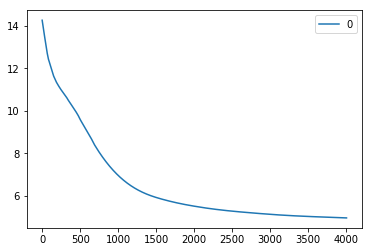

In [8]:
loss_function = pd.DataFrame(a.loss_curve_).plot()

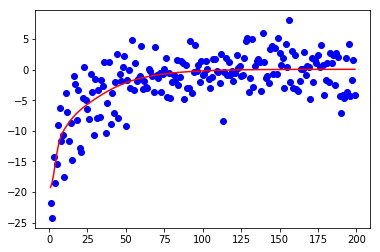

In [9]:
# Plot the neural network output 

pred_x = np.reshape(x, [-1, 1]) 
pred_y = clf.predict(pred_x) # predict network output given x_
fig = plt.figure() 
plt.scatter(x, y, color = 'b') # plot original function
plt.plot(pred_x, pred_y, 'r') # plot network output

Let us now fit an exponential function on the output of the neural network. The parameters of the exponential fit will be used to define the reactive volatility in section II.
The parameter **a gives the amplitude of the leverage effect, while the parameter b gives the typical relaxation time of this effect in the financial markets.** 

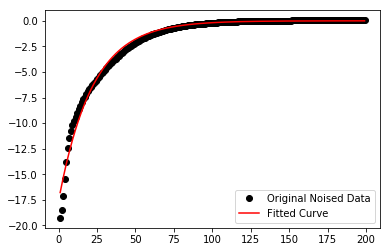

array([-17.5750315 ,  21.86565142])

In [10]:
# Exponential fit on the output of the neural network

def func(x, a, b):
  return a * np.exp(-x/b) 

x =  mean_leverage_train_df["Tau"]

popt, pcov = curve_fit(func, x, pred_y,p0 = (-18,10))

plt.figure()
plt.plot(x, pred_y, 'ko', label="Original Noised Data")
plt.plot(x, func(x, *popt), 'r-', label="Fitted Curve")

plt.legend()
plt.show()
popt

### 1.4 - Validation of our predicted parameters on the test set 

Let's check whether our predicted parameters yield satisfying results on the test set

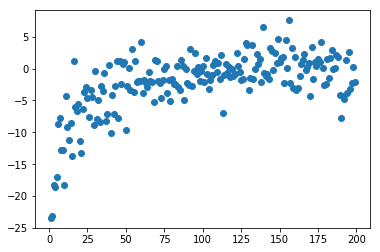

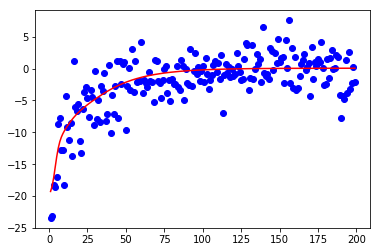

In [11]:
x =  mean_leverage_test_df["Tau"]
x = x.values

y = mean_leverage_test_df["Mean Leverage Test"] 
X = np.reshape(x,[n,1]) 
y = np.reshape(y ,[n ,])

plt.scatter(x,y)

test_x = np.reshape(x, [-1, 1]) 

test_y = clf.predict(test_x) # Vérifions le fit donné 
fig = plt.figure() 
plt.scatter(x, y, color = 'b') # plot original function
plt.plot(pred_x, test_y, 'r') # plot network output

Let's compute the prediction error 

In [12]:
from sklearn.metrics import mean_squared_error

y_true  = y
y_pred = test_y

print("Error on the test set:",mean_squared_error(y_true,y_pred))
print("Error on the training set:",a.loss_)
print("% Error increase:", round((mean_squared_error(y_true,y_pred)-a.loss_)/a.loss_*100,2),"%")


Error on the test set: 8.274217463635285
Error on the training set: 4.94305175035439
% Error increase: 67.39 %
